# Contract machine

The dynamics equations were taken from this tutorial on system behavior:
- [Aircraft pitch: System modelling](https://ctms.engin.umich.edu/CTMS/index.php?example=AircraftPitch&section=SystemModeling)

In [1]:
using AlgebraicDynamics.DWDDynam
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Graphics.Graphviz
using DifferentialEquations
using Plots
#-------
using IntervalSets  # Library is required to create intervals of real numbers
using PrettyTables
using LabelledArrays

In [2]:
# Add machine type module
include("contract_machine.jl")
#using .StaticContract

Main.StaticContract

### UAV Example

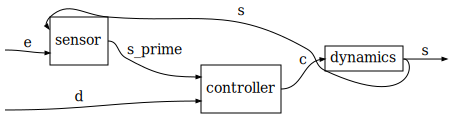

In [3]:
s = Box(:sensor    , [:s, :e]      , [:s_prime])
c = Box(:controller, [:s_prime, :d], [:c])
d = Box(:dynamics  , [:c]          , [:s])

# Diagram:           Inputs, Outputs <- Ports of entire diagram
UAV = WiringDiagram([:e,:d], [:s])

# Associate boxes to diagram
sensor     = add_box!(UAV, s)
controller = add_box!(UAV, c)
dynamics   = add_box!(UAV, d)

add_wires!(UAV, [
  # Net Inputs      
  (input_id(UAV),1) => (sensor,2),
  (input_id(UAV),2) => (controller,2),
  # Connections
  (sensor,1) => (controller,1),
  (controller,1) => (dynamics,1),
  (dynamics,1) => (sensor,1),
  # Net Outputs
  (dynamics,1) => (output_id(UAV),1)
])

to_graphviz(UAV, orientation=LeftToRight, labels=true)

In [6]:
# State functions: 
equation_sensor(u, x, p, t)  = [ -p.λs*(u[1] - x[1] - x[2]) ];        # x = [θ, e] -> [Pitch angle, pitch offset]

equation_control(u, x, p, t) = [ -p.λc*(u[1] + p.kθ*x[1] - x[2]) ];   # x = [Sl, d] -> [sensor output, control input]

equation_dynamic(u, x, p, t) = [ -0.313*p.v*u[1] +  56.7*u[2] +  0.232*p.v*x[1]      ,    # α -> Angle of attack
                              ( -0.0139*p.v*u[1] - 0.426*u[2] + 0.0203*p.v*x[1] )*p.v,    # q -> Angular velocity
                                                    56.7*u[2]                        ];   # θ -> Pitch angle    
                                                                                          # x = [Sc] -> Controller output 
# Readout functions:  [select specific state]
readout_sensor(u, p, t)  = [ u[1] ];  # sl
readout_control(u, p, t) = [ u[1] ];  # sc
readout_dynamic(u, p ,t) = [ u[3] ];  # θ

# contract intervals                # variable in question:
s_in = [ -0.2..0.2, -0.1..0.3 ]     # [s, e]
s_out = [ -0.8.. 0.8 ]              # [s_prime]

c_in = [ -0.1..0.1, -0.1..0.3 ]     # [s_prime, d]
c_out = [ -0.1.. 0.1 ]              # [c] 

d_in = [ -0.2..0.2 ]                # [c]
d_out = [ -0.1.. 0.1 ]              # [s]

# Machines for each box in diagram:
                              # Inputs, Outputs, States
s_machine = StaticContract.ContractMachine{Float64}( s_in, 1, s_out, equation_sensor, readout_sensor );
c_machine = StaticContract.ContractMachine{Float64}( c_in, 1, c_out, equation_control, readout_control ); 
d_machine = StaticContract.ContractMachine{Float64}( d_in, 3, d_out, equation_dynamic, readout_dynamic ); 

    # Output composition
comp = StaticContract.oapply( UAV, [s_machine, c_machine, d_machine] )

┌ Warning: contract -0.8..0.8 of sensor is undefined at the contract -0.1..0.1 of controller at wire s_prime
└ @ Main.StaticContract /home/bobby/Desktop/composition_notebook/machines/contract_machine/contract_machine.jl:122


ContractMachine( [-0.1,0.3] × [-0.1,0.3] × [-0.1,0.1] )

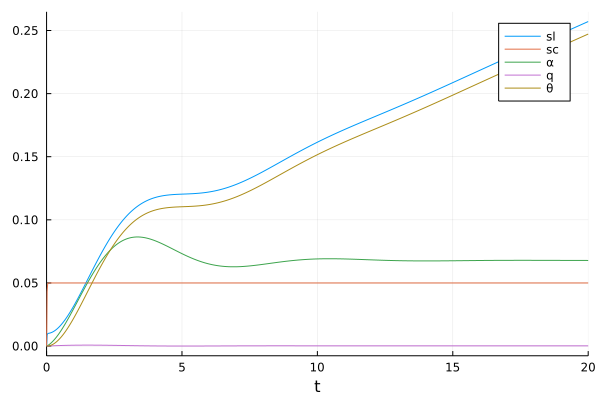

In [7]:
# Initial values
x_init = LVector(e=0.01, d=0.05);                # Inputs: [e, d] -> [θ offset, 𝛿 control input]
u_init = LVector(sl=0, sc=0, α=0, q=0, θ=0);     # States: [sl, sc, α, q, θ]

# Integration interval
t_span = (0, 20); 

# Parameters:
param = (λs = 100, # Decay constant of sensor
         λc = 100, # Decay constant of controller
         kθ = 0,   # Gain of control input proportional to sensor output. Causes a feedback loop.
         v  = 1);   # Ratio of velocity to reference velocity

# solve system 
sol = solve( StaticContract.ODEProblem(comp, u_init, x_init, t_span, param), alg_hints=[:stiff] )
plot(sol)

In [8]:
us = [1]
s_machine.fcontract( us, x_init, param )

input,output
port: contract,port: contract
1 : true2 : true,1 : false


In [9]:
comp.fcontract( u_init, x_init, param )

box,input,output
directory,wire: contract,wire: contract
controller,s_prime : trued : true,c : true
dynamics,c : true,s : true
sensor,s : truee : true,s_prime : true


In [10]:
dict = StaticContract.check_contract(sol, comp, x_init, param)

box,input,output
directory,wire: failure interval,wire: failure interval
controller,"s_prime : 3.231656 , 20.000000",
dynamics,,"s : 3.846184 , 20.000000"
sensor,"s : 16.280573 , 20.000000",


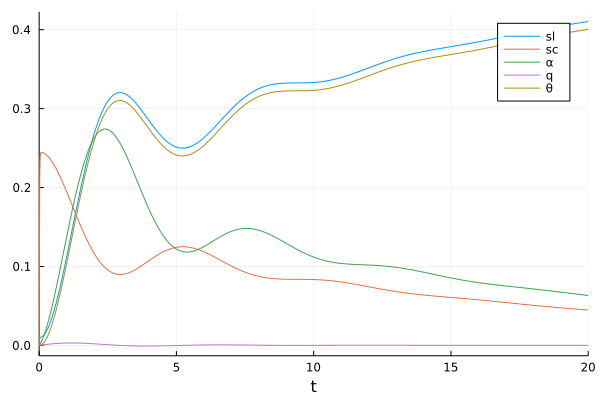

In [11]:
# Parameters:
param = (λs = 100, 
         λc = 100,
         kθ = 0.5,           # Small feedback gain
         v = 1);   
                     
x_init = LVector(e=0.01, d=0.25);       
      
# solve system 
sol = solve(StaticContract.ODEProblem(comp, u_init, x_init, t_span, param), alg_hints=[:stiff] )
plot(sol)

In [12]:
dict = StaticContract.check_contract(sol, comp, x_init, param)

box,input,output
directory,wire: failure interval,wire: failure interval
controller,"s_prime : 1.112148 , 20.000000","c : 0.005199 , 2.085530c : 3.763980 , 6.420558"
dynamics,"c : 0.017860 , 0.859003","s : 1.112148 , 20.000000"
sensor,"s : 1.725984 , 20.000000",


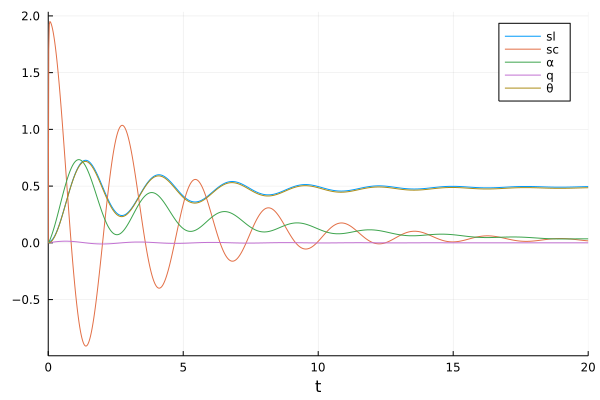

In [13]:
# Parameters:
param = (λs = 100, 
         λc = 100,
         kθ = 4,     # Larger gain 
         v = 1);     # Increase the velocity of the aircraft 
                     
x_init = LVector(e=0.01, d=2);       
      
# solve system 
sol = solve( StaticContract.ODEProblem(comp, u_init, x_init, t_span, param), alg_hints=[:stiff] )
plot(sol)

In [14]:
dict = StaticContract.check_contract(sol, comp, x_init, param)

box,input,output
directory,wire: failure interval,wire: failure interval
controller,"s_prime : 0.340646 , 20.000000d : 0.000000 , 20.000000","c : 0.001109 , 1.784190c : 2.213758 , 3.313264c : 3.792428 , 6.110392c : 6.656184 , 6.929079c : 7.774501 , 8.633291c : 10.604049 , 11.196291c : 13.553978 , 13.553978"
dynamics,"c : 0.001109 , 0.724479c : 1.042279 , 1.784190c : 2.213758 , 3.313264c : 3.792428 , 4.278879c : 5.050448 , 5.837497c : 7.774501 , 8.633291","s : 0.340646 , 20.000000"
sensor,"s : 0.577182 , 20.000000",
